![Digital Earth Pacific](dep.png)

In [1]:
import geopandas as gpd
import joblib
import numpy as np
import odc.geo.xr  # noqa: F401
import pandas as pd
import xarray as xr
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier
from dask.distributed import Client as dask_client
from depal_fj import get_image_values
import depal_fj as dep

In [2]:
%reload_ext autoreload
%autoreload 2

## Load study area

Load data and set up your array to use for prediction

In [3]:
# Configure some things up front
chunks = dict(x=100, y=100)
year = "2023"

aoi = dep.get_island("Viti Levu")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [4]:
catalog = "https://stac.staging.digitalearthpacific.org"
client = Client.open(catalog)

# Search for Sentinel-2 GeoMAD data
items = client.search(
    collections=["dep_s2_geomad"],
    bbox=bbox,
    datetime=year
).items()

# Load the data
data = load(items, chunks=chunks, bbox=bbox, resolution=10).squeeze("time")

#coastal clip
data = dep.do_coastal_clip(aoi, data, buffer=0)
data

<xarray.Dataset>
Dimensions:      (y: 11207, x: 15526)
Coordinates:
  * y            (y) float64 -1.944e+06 -1.944e+06 ... -2.056e+06 -2.056e+06
  * x            (x) float64 3.033e+06 3.033e+06 ... 3.188e+06 3.188e+06
    time         datetime64[ns] 2023-01-01
    spatial_ref  int64 0
Data variables: (12/14)
    B02          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...           ...
    B12          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B8A          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    emad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    count        (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>

In [5]:
training_file = "Fiji/fj_lulc_data_points_merged.gpkg"

training_data = gpd.read_file(training_file, bbox=bbox_geometry)
training_data.explore(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Satellite",
    column="Class"
)

<Axes: xlabel='Class'>

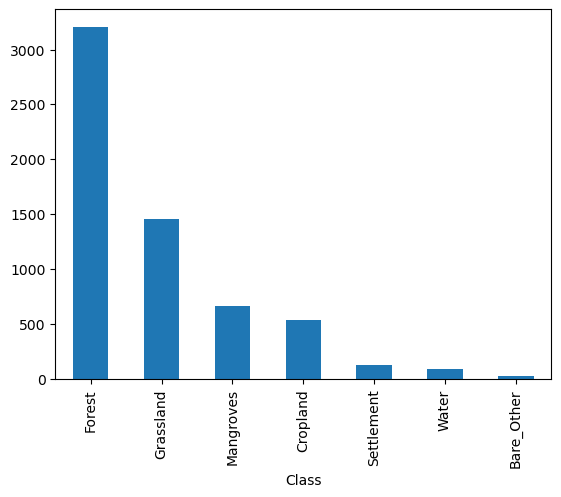

In [6]:
# Count the values in a specific column (e.g., "Class" column)
class_counts = training_data['Class'].value_counts()

# Display the counts
class_counts.plot.bar()

In [7]:
# Subset the training data to a smaller sample size, if required
#subset = training_data.sample(1000)
subset = training_data

with dask_client(
    n_workers=16, threads_per_worker=16, memory_limit="10GB"
):
    variables = get_image_values(subset, data)

variables.head()

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 21.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,y,x,time,spatial_ref,B02,B03,B04,B05,B06,B07,B08,B11,B12,B8A,emad,smad,bcmad,count
index,,,,,,,,,,,,,,,,,,
0,-2038805.0,3064125.0,2023-01-01,0,368.0,582.0,405.0,976.0,2490.0,3022.0,3001.0,1876.0,951.0,3278.0,965.381409,0.005044,0.075873,35.0
1,-2040225.0,3064135.0,2023-01-01,0,317.0,556.0,331.0,965.0,3484.0,4503.0,4622.0,1781.0,777.0,4825.0,1355.962036,0.001658,0.069050,39.0
2,-2041645.0,3064135.0,2023-01-01,0,368.0,692.0,451.0,1210.0,2908.0,3390.0,3337.0,2241.0,1144.0,3723.0,1341.804932,0.004156,0.087856,36.0
3,-2038795.0,3065545.0,2023-01-01,0,318.0,649.0,307.0,1076.0,3187.0,3818.0,3814.0,1814.0,801.0,4106.0,686.262817,0.000696,0.043037,38.0
4,-2040215.0,3065555.0,2023-01-01,0,350.0,717.0,356.0,1208.0,3254.0,3845.0,4125.0,2176.0,1053.0,4155.0,904.376404,0.000778,0.052826,37.0


In [8]:
# Sort the variables by name, so they're in a consistent order
sorted_variables = variables.sort_index(axis=1)

# Join the new variables to the original points and drop non-required columns
training_array = pd.concat([training_data["ClassId"], sorted_variables], axis=1)
training_array = training_array.drop(columns=['time','x','y','spatial_ref'])

# Drop rows where there are any NaNs
training_array = training_array.dropna()

# Explore our data
training_array.head()

,ClassId,B02,B03,B04,B05,B06,B07,B08,B11,B12,B8A,bcmad,count,emad,smad
0,1,368.0,582.0,405.0,976.0,2490.0,3022.0,3001.0,1876.0,951.0,3278.0,0.075873,35.0,965.381409,0.005044
1,2,317.0,556.0,331.0,965.0,3484.0,4503.0,4622.0,1781.0,777.0,4825.0,0.069050,39.0,1355.962036,0.001658
2,3,368.0,692.0,451.0,1210.0,2908.0,3390.0,3337.0,2241.0,1144.0,3723.0,0.087856,36.0,1341.804932,0.004156
3,3,318.0,649.0,307.0,1076.0,3187.0,3818.0,3814.0,1814.0,801.0,4106.0,0.043037,38.0,686.262817,0.000696
4,3,350.0,717.0,356.0,1208.0,3254.0,3845.0,4125.0,2176.0,1053.0,4155.0,0.052826,37.0,904.376404,0.000778


In [9]:
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
)

training_data = np.array(training_array)[:, 1:]
classes = np.array(training_array)[:, 0]

model = classifier.fit(training_data, classes)

In [10]:
# Print feature importances against column headings
fields_importances = sorted(
    zip(training_array.columns[1:], classifier.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)

for i in fields_importances:
    # Format as a table to 2 decinal places
    print(f"{i[0]:<11}| {i[1]:.2f}")


B12        | 0.20
B11        | 0.12
B04        | 0.11
B05        | 0.09
B03        | 0.09
B02        | 0.06
B08        | 0.06
B07        | 0.05
B8A        | 0.04
smad       | 0.04
B06        | 0.04
count      | 0.03
bcmad      | 0.03
emad       | 0.03


## Export the model for use in the prediction notebook

In [11]:
joblib.dump(model, "fj_lulc.model")

['fj_lulc.model']

In [12]:
print("Model Trained.")

Model Trained.
